# Distort character images

Program works by loading images from their respective folders in the central data store, applying specified distortions to reduce the quality and then saving the image back to the correct folder.

Update *num_images_wanted* to the number of images variant wanted for each character. If current number of images > *num_images_wanted* for a character, the character will be skipped

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
from wand.api import library
import wand.color
import wand.image
import numpy as np
from skimage import measure
from PIL import Image
from scipy import ndimage
import random
import pandas as pd
from character_translation_load import DatasetLoad

data_dir = './source'
img_filetype = '.png'
test = True

desired_variants = 50

In [22]:
# renames images to proper format (overrides current names)

from tqdm import tqdm
image_dir = "./images"

files = os.listdir(image_dir)
# files.sort()

for file in tqdm(files):
    images = os.listdir(image_dir + os.sep + file)
    for ii, image in enumerate(images):
        prefix = image_dir + os.sep + file + os.sep 
        # print(prefix + image, prefix + f"{file}-{i+1}.png")
        os.rename(prefix + image, prefix + f"{file}-{ii+1}.png")
    # break

100%|██████████| 1076/1076 [00:00<00:00, 27491.40it/s]


In [ ]:
from character_translation_load import DatasetLoad

In [9]:
# Param: file - the filename of the image e.g. 1_1, 3_10, 150_2 etc.
# Returns image as numpy array
def load_image(file):
#     img_folder = file[0:file.index('_')]
    img = Image.open(file).convert('L')
    
    im = np.asarray(img)
        
    return im

In [116]:
def resize_all_images():
    for root, dirs, files in os.walk(data_dir):
        for name in files:
            if '.png' in name:
#                 print(name[:name.index(".")])
                im = load_image(name[:name.index(".")])
                resized_image = pad_image((512,512), im.shape, im)
                plt.imsave(os.path.join(root, name), resized_image, cmap='gray')
                print(f'Saved resized image at {os.path.join(root, name)}')

def downsize_images(csvFile, i, new_height, new_width):
    data = pd.read_csv(csvFile, names = ["img", "label"])
    print(data)
    for x in range(len(data["img"])):
        if data["label"][x] > i:
            break
        im = Image.open(data["img"][x]).convert("L")
        img = im.resize((new_height, new_width))
        img.save(data["img"][x])
        
def binarise_image(im, thresh):
    idx = (im < thresh)
    
    binary_im = np.zeros(im.shape, dtype='int')
    
    binary_im[idx] = 255
    binary_im[~idx] = 0
    
    return binary_im

def extract_character(im):
    binary_im = binarise_image(im, 200) # Input images should be black & white anyway, so 128 is arbitrary

    # threshold at 200
    threshed = np.zeros(im.shape, 'int')
    threshed[im<200] = 1
    
    comps = measure.label(threshed, background=0)
    
    component_map, labels = comps, np.unique(comps)

    min_x = im.shape[0]
    min_y = im.shape[1]
    max_x = 0
    max_y = 0
    for label in labels[1:]:
        char_box = char_bounding_box(component_map, label)
        min_x = np.min(np.array([min_x, char_box[0]]))
        min_y = np.min(np.array([min_y, char_box[1]]))
        max_x = np.max(np.array([max_x, char_box[2]]))
        max_y = np.max(np.array([max_y, char_box[3]]))

    extracted_char = np.array(im[min_y:max_y, min_x:max_x])

    return extracted_char
    
# find the coordinate bounding box of a given label in a components image
def char_bounding_box(comps, label=1):
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)   

# Return image im with size shape_from after padding with 255 (white) to size shape_to
def pad_image(shape_to, shape_from, im):
    print(f"Original size: {im.shape}")
    padded_image = np.pad(im, ((500,500),(500,500)), 'constant', constant_values=(255))

    if shape_from[0] > shape_to[0] and shape_from[1] > shape_to[1]:
        cropped_image = Image.fromarray(im).resize(shape_to)
    else:
        cropped_image = padded_image[padded_image.shape[0]//2-shape_to[0]//2:padded_image.shape[0]//2+shape_to[0]//2, padded_image.shape[1]//2-shape_to[1]//2:padded_image.shape[1]//2+shape_to[1]//2]
    print(f"Cropped size: {cropped_image.shape}")
    return cropped_image

In [115]:
def rotate_char(im, std, rot):
    
    extracted_char = extract_character(im)
    rotated_char = ndimage.rotate(extracted_char, rot, reshape=True, mode='constant', cval=255)
    
#     if rotated_char.shape[0] < im.shape[0] and rotated_char.shape[1] < im.shape[1]:
    rotated_image = pad_image((im.shape[0],im.shape[1]), rotated_char.shape, rotated_char)
#     else:
#         rotated_image = rotated_char
    
    return rotated_image

def add_gaussian_noise(img, std, rot):
    noise = np.random.normal(0, std, img.shape) 

    # Add the noise to the image
    img_noised = img + noise

    # Clip the pixel values to be between 0 and 255.
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    
    return img_noised

def add_gaussian_blur(img, std, rot):
    std = int(std//10)
    gauss_blurred = ndimage.gaussian_filter(img, std)
    
    return gauss_blurred

def remove_block(img, std, rot):
    block_size = 20
    extracted_char = extract_character(img)
#     print(extracted_char.shape)
    block_size = min(block_size, extracted_char.shape[0])
    block_size = min(block_size, extracted_char.shape[1])
    rand_x = random.randint(0, extracted_char.shape[0]-block_size)
    rand_y = random.randint(0, extracted_char.shape[1]-block_size)
#     print(rand_x, rand_y)
    extracted_char[rand_x:rand_x+block_size, rand_y:rand_y+block_size] = 255
    
    
    padded_image = pad_image((img.shape[0],img.shape[1]), extracted_char.shape, extracted_char)
    return padded_image

def phase_swap(img, std, rot):
    A = img
    
    # now dft and swap phases
    dft_A = np.fft.fft2(A)
    mag_A = np.abs(dft_A)
    angle_A = np.angle(dft_A)
    
    ref_img = Image.open(os.path.join(data_dir, 'zebra.gif')).convert('L')
    ref_im = np.asarray(ref_img)
    ref_img_resized = ref_img.resize((img.shape[0], img.shape[1]))
    dft_B = np.fft.fft2(ref_img_resized)
    mag_B = np.abs(dft_B)
    angle_B = np.angle(dft_B)

    dft_B2 = mag_B * np.exp(1j*angle_A)

    # inverse dft
    B2 = np.fft.ifft2(dft_B2).real
    
    return B2


In [113]:
def add_effects(im):
    ### Function parameters:
    #   im - the input image
    #   std - the standard deviation of gaussian filters, 1 <= std <= 100
    #   rot - the degree of rotation, -90 <= rot <= 90

    effects = { # CAN ADD HORIZONTAL FLIP
        1: rotate_char,
        2: remove_block,
        3: phase_swap,
        4: add_gaussian_blur,
        5: add_gaussian_noise
    }
        
    num_effects = random.randint(1, len(effects))
    effect_image = np.copy(im)
    
    for f in range(1, num_effects+1):
        print(f"Effect: {f}")
        effect_image = effects[f](effect_image, random.randrange(10, 50, 10), random.randint(-30, 30))
        
    return effect_image

def make_variant(im_filename, variant_filename):
    im = load_image(im_filename)
    edited_image = add_effects(im)
    
    plt.imsave(variant_filename, edited_image, cmap='gray')

In [121]:
### MAIN FUNCTION CELL - RUN TO DISTORT ALL IMAGES IN FOLDER

# get csv of all image paths
if not os.path.exists(os.path.join(data_dir, 'trainData.csv')):
    DatasetLoad(data_dir, 1076, 'trainData.csv').createCsv() 

def main():
    if os.path.exists(os.path.join(data_dir, 'trainData.csv')):
        df = pd.read_csv(os.path.join(data_dir,'trainData.csv'), sep=",", names = ["img", "label"])
        name = df[df["label"] == 1]["img"][0][:]
        # Loop over characters
        for i in range(1, len(trainData)+1):
            variant_num = 1

            # Number of images currently in folder for character i
            num_variants = len(df[df["label"] == i])

            # Calculate number of variant images to make for each image in folder
            div = num_variants
            num = desired_variants - num_variants
            variants_to_make = ([num // div + (1 if x < num % div else 0)  for x in range (div)])

            # Loop over images in character folder
            for j in range(num_variants):
                # Make required number of variants for each image
                for k in range(variants_to_make[j]):
                    # Make filename for new image
                    variant_filename = data_dir + '/' + str(i) + '/' + str(i) + '_' + str(num_variants+variant_num) + '.png'

                    # Make new variant image
                    make_variant(df[df["label"] == i].iloc[j]["img"], variant_filename)

                    # Increment to get next variant number for next new image filename
                    variant_num += 1
    else:
        print('[INFO] Image path csv does not exist, create in data directory.')

main()

Effect: 1
Original size: (94, 86)
Cropped size: (128, 128)
Effect: 2
Original size: (73, 66)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (79, 64)
Cropped size: (128, 128)
Effect: 2
Original size: (74, 58)
Cropped size: (128, 128)
Effect: 1
Original size: (81, 70)
Cropped size: (128, 128)
Effect: 2
Original size: (71, 55)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (87, 80)
Cropped size: (128, 128)
Effect: 2
Original size: (72, 59)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (129, 129)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (138, 138)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (172, 172)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (142, 142)
Cropped size: (1

Original size: (136, 136)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (81, 58)
Cropped size: (128, 128)
Effect: 2
Original size: (76, 52)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (91, 75)
Cropped size: (128, 128)
Effect: 2
Original size: (74, 54)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (93, 91)
Cropped size: (128, 128)
Effect: 2
Original size: (74, 60)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (76, 73)
Cropped size: (128, 128)
Effect: 2
Original size: (75, 72)
Cropped size: (128, 128)
Effect: 1
Original size: (133, 133)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (151, 151)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (91, 83)
Cropped size: (128

Effect: 1
Original size: (164, 164)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (145, 145)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (154, 154)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (161, 161)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (156, 156)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (152, 152)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (151, 151)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (165, 165)
Cropped si

Effect: 1
Original size: (131, 131)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (145, 145)
Cropped size: (128, 128)
Effect: 1
Original size: (154, 154)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (161, 161)
Cropped size: (128, 128)
Effect: 1
Original size: (90, 70)
Cropped size: (128, 128)
Effect: 2
Original size: (71, 59)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (81, 50)
Cropped size: (128, 128)
Effect: 2
Original size: (78, 46)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (173, 173)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (131, 131)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (90, 66)
Cropped si

Original size: (96, 90)
Cropped size: (128, 128)
Effect: 2
Original size: (76, 52)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (97, 90)
Cropped size: (128, 128)
Effect: 2
Original size: (77, 53)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (93, 81)
Cropped size: (128, 128)
Effect: 2
Original size: (73, 68)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (160, 160)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (92, 86)
Cropped size: (128, 128)
Effect: 2
Original size: (76, 51)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (133, 133)
Cropped size: (128, 128)
Effect: 1
Original size: (86, 74)
Cropped size: (128, 128)
Effect: 1
Original size: (151, 151)
Cropped size: (128, 128)
Effect: 1
Original size: (95, 86)
Cropped size: (128, 128)
Effect: 2
Original size: (72, 70)
Cropped size: (128, 128)
Effect: 3
Effect:

Effect: 1
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (90, 77)
Cropped size: (128, 128)
Effect: 2
Original size: (85, 72)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (89, 74)
Cropped size: (128, 128)
Effect: 2
Original size: (84, 70)
Cropped size: (128, 128)
Effect: 1
Original size: (172, 172)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (129, 129)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (100, 89)
Cropped size: (128, 128)
Effect: 2
Original size: (86, 79)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (95, 82)
Cropped size: (128, 128)
Effect: 2
Original size: (85, 75)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
Original size: (152, 152)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (167, 167)
Crop

Effect: 1
Original size: (173, 173)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 1
Original size: (167, 167)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 1
Original size: (152, 152)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (145, 145)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (82, 62)
Cropped size: (128, 128)
Effect: 2
Original size: (61, 48)
Cropped size: (128, 128)
Effect: 1
Original size: (81, 57)
Cropped size: (128, 128)
Effect: 1
Original size: (173, 173)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 1
Original size: (161, 161)
Cropped size: (128, 128)
Effect: 2
Original size: (127, 127)
Cropped size: (128, 128)
Effect: 3
Effect: 4
Effect: 5
Effect: 1
O

KeyboardInterrupt: 

(512, 512)


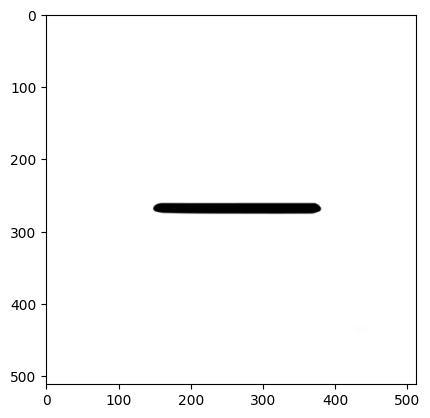

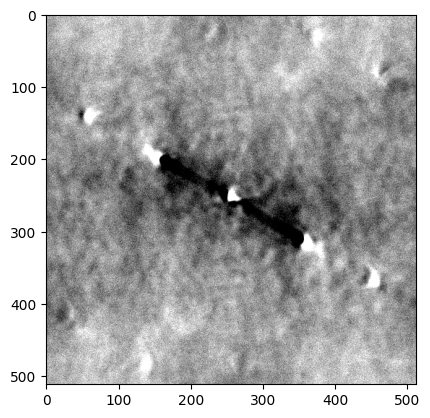

In [67]:
### DOWNSIZE IMAGES TO DESIRED RESOLUTION

# downsize images to desired resolution
downsize_images('./source/trainData.csv', 1076, 128, 128)

In [9]:
## Rename all files to have format <char_index>_<image_num>.png 

for root, dirs, files in os.walk(data_dir):
    num = 1
    for name in files:
        if '.png' in name and "_" not in name:
            new_filename = root[root.index("\\")+1:] + "_" + str(num) + '.png'
            os.rename(os.path.join(root, name), os.path.join(root, new_filename))
            num+=1


./source
['empty_folders.txt', 'hsk.csv', 'hsk_1.csv', 'hsk_1.txt', 'hsk_1_formatted.csv', 'hsk_1_formatted.txt', 'hsk_2.txt', 'hsk_3.txt', 'hsk_4.txt', 'log - Copy.txt', 'log.txt', 'log_2.txt', 'missing_chars.csv', 'testimage512.gif', 'zebra.gif', 'zelda.pgm']
./source\1
['1_1.png', '1_10.png', '1_11.png', '1_12.png', '1_13.png', '1_14.png', '1_15.png', '1_16.png', '1_17.png', '1_18.png', '1_19.png', '1_2.png', '1_20.png', '1_3.png', '1_4.png', '1_5.png', '1_6.png', '1_7.png', '1_8.png', '1_9.png']
./source\10
['10_1.png', '10_10.png', '10_11.png', '10_12.png', '10_13.png', '10_14.png', '10_15.png', '10_16.png', '10_17.png', '10_18.png', '10_19.png', '10_2.png', '10_3.png', '10_4.png', '10_5.png', '10_6.png', '10_7.png', '10_8.png', '10_9.png']
./source\100
['100_1.png', '100_10.png', '100_11.png', '100_12.png', '100_13.png', '100_14.png', '100_15.png', '100_16.png', '100_17.png', '100_18.png', '100_19.png', '100_2.png', '100_3.png', '100_4.png', '100_5.png', '100_6.png', '100_7.png',

./source\548
['548_1.png', '548_10.png', '548_11.png', '548_12.png', '548_13.png', '548_14.png', '548_15.png', '548_16.png', '548_17.png', '548_18.png', '548_19.png', '548_2.png', '548_3.png', '548_4.png', '548_5.png', '548_6.png', '548_7.png', '548_8.png', '548_9.png']
./source\549
['549_1.png', '549_10.png', '549_11.png', '549_12.png', '549_13.png', '549_14.png', '549_15.png', '549_16.png', '549_17.png', '549_18.png', '549_19.png', '549_2.png', '549_3.png', '549_4.png', '549_5.png', '549_6.png', '549_7.png', '549_8.png', '549_9.png']
./source\55
['55_1.png', '55_10.png', '55_11.png', '55_12.png', '55_13.png', '55_14.png', '55_15.png', '55_16.png', '55_17.png', '55_18.png', '55_19.png', '55_2.png', '55_3.png', '55_4.png', '55_5.png', '55_6.png', '55_7.png', '55_8.png', '55_9.png']
./source\550
['550_1.png', '550_10.png', '550_11.png', '550_12.png', '550_13.png', '550_14.png', '550_15.png', '550_16.png', '550_17.png', '550_18.png', '550_19.png', '550_2.png', '550_3.png', '550_4.png', '

./source\942
['942_1.png', '942_10.png', '942_11.png', '942_12.png', '942_13.png', '942_14.png', '942_15.png', '942_16.png', '942_17.png', '942_18.png', '942_19.png', '942_2.png', '942_3.png', '942_4.png', '942_5.png', '942_6.png', '942_7.png', '942_8.png', '942_9.png']
./source\943
['943_1.png', '943_10.png', '943_11.png', '943_12.png', '943_13.png', '943_14.png', '943_15.png', '943_16.png', '943_17.png', '943_18.png', '943_19.png', '943_2.png', '943_3.png', '943_4.png', '943_5.png', '943_6.png', '943_7.png', '943_8.png', '943_9.png']
./source\944
['944_1.png', '944_10.png', '944_11.png', '944_12.png', '944_13.png', '944_14.png', '944_15.png', '944_16.png', '944_17.png', '944_18.png', '944_19.png', '944_2.png', '944_3.png', '944_4.png', '944_5.png', '944_6.png', '944_7.png', '944_8.png', '944_9.png']
./source\945
['945_1.png', '945_10.png', '945_11.png', '945_12.png', '945_13.png', '945_14.png', '945_15.png', '945_16.png', '945_17.png', '945_18.png', '945_19.png', '945_2.png', '945_3.